## NYC Bike Share (Citi Bike) Locations 
From a monthly citibike tripdata file extract the stations used that month.<br>
Augment with geographical details for each station using reverse geocoding

Import libraries for pandas and geocoding

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

### Import Trip Data File
Get file from Citi Bike.<br>From Linux terminal session:
```md bikeshare 
cd bikeshare 
wget https://s3.amazonaws.com/tripdata/202009-citibike-tripdata.csv.zip
unzip 202009-citibike-tripdata.csv.zip
rm 2020009-citibike-tripdata.csv.zip```

Read file into DataFrame

In [2]:
df = pd.read_csv('bikeshare/202009-citibike-tripdata.csv')
df.shape

(2488225, 15)

### Counting Trips

Count number of unique start and end stations

In [3]:
counts = df[['start station id','end station id']].nunique()
counts

start station id    1087
end station id      1112
dtype: int64

Calculate theoretical maximum number of unique trips

In [4]:
counts.agg('product')

1208744

Calculate actual number of unique trips

In [5]:
df[['start station name','end station name']].value_counts().count()

317636

Create series with top twenty most popular trips.<br>
Create series with names for them.
Plot them

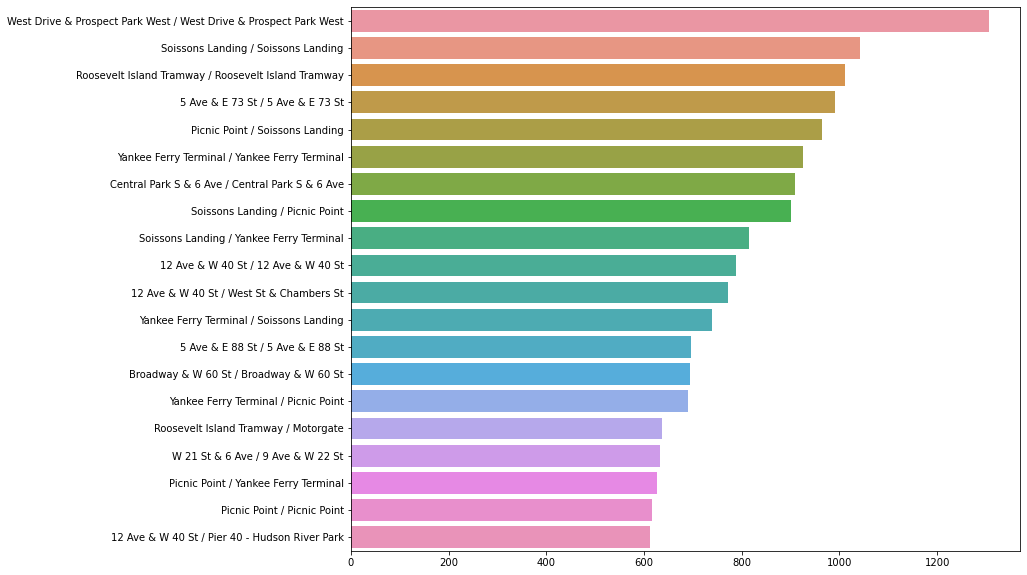

In [6]:
trips=df.value_counts(['start station name','end station name'])[:20]
trip_names=[trips.index[t][0] + ' / ' + trips.index[t][1] for t in range(len(trips))]
plt.figure(figsize=(12,10))
sns.barplot( x= list(trips.values), y = trip_names, orient="h") ;

Rerun omitting loops - stations where start and end stations are the same

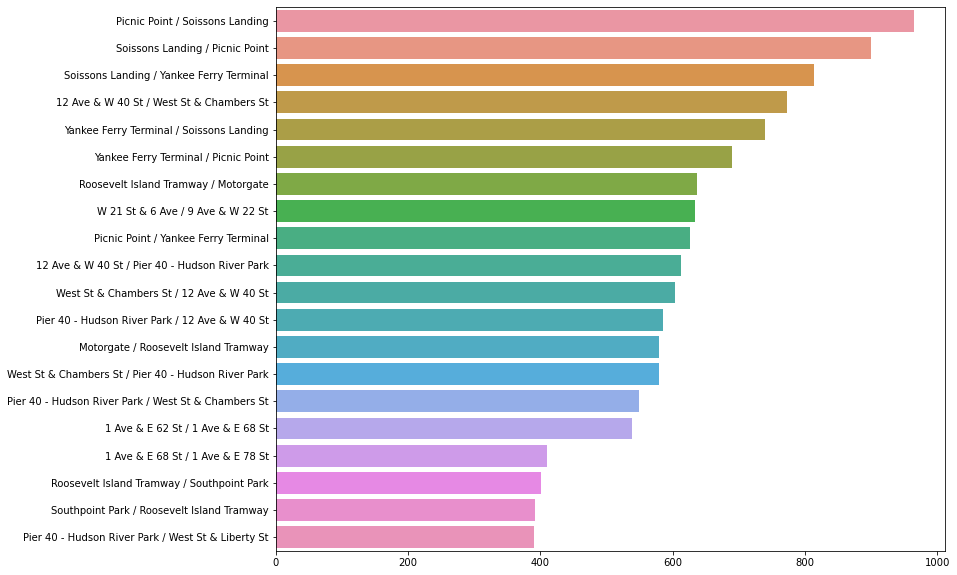

In [7]:
trips = df[df['start station id'] != df['end station id']].value_counts(['start station name','end station name'])[:20]
trip_names=[trips.index[t][0] + ' / ' + trips.index[t][1] for t in range(len(trips))]
plt.figure(figsize=(12,10))
sns.barplot( x= list(trips.values), y = trip_names, orient="h") ;

Note frequency of trips between stations Picnic Point, Soissons Landing, Yankee Ferry terminal. These don't sound like Manhattan locations. Where are they?

### Reverse Geocoding

Create reverse function with one second delay 

In [8]:
geolocator = Nominatim(user_agent="bikeshare")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1, max_retries=0)

Test reverse with latitude/longitude pair<br>
From raw format extract address JSON document 

In [9]:
reverse("40.75029943702441, -73.99221868612786").raw['address']

{'building': 'Two Penn Plaza',
 'house_number': '2',
 'road': '7th Avenue',
 'neighbourhood': 'Chelsea',
 'suburb': 'Manhattan',
 'county': 'New York County',
 'city': 'New York',
 'state': 'New York',
 'postcode': '10001',
 'country': 'United States',
 'country_code': 'us'}

### Create Table of Station Names

For unique values of "start station id" extract start station name, latitude, longitude into a Pandas DataFrame.

In [10]:
dfs=df[['start station id','start station name','start station latitude','start station longitude']]\
.drop_duplicates(subset = ['start station id'])

Rename columns to remove "start." <br>
Set index to `stationid`.

In [11]:
dfs.columns=['stationid','station name','latitude','longitude']
dfs.set_index('stationid', inplace=True)
dfs

,station name,latitude,longitude
stationid,,,
3508,St Nicholas Ave & Manhattan Ave,40.809725,-73.953149
3621,27 Ave & 9 St,40.773983,-73.930913
3492,E 118 St & Park Ave,40.800539,-73.941995
3946,St Nicholas Ave & W 137 St,40.818477,-73.947568
3081,Graham Ave & Grand St,40.711863,-73.944024
...,...,...,...
4159,3 Ave & E 172 St,40.839586,-73.900277
4161,3 Ave & E 174 St,40.842240,-73.898500
4202,Dawson St & Intervale Ave,40.819999,-73.897263


### Reverse Geocode Stations

Call reverse for each station, formatting latitude and longitude as text string.<br>
Create locations as a list of dictionaries for each station.

Since there is a limit of one request per second, and 1087 stations, this takes 18 minutes!<br>
See below to download saved file and skip this step.

In [12]:
locations=[]
for index, row in dfs.iterrows():
    locations.append(reverse("{}, {}".format(row['latitude'], row['longitude'])).raw['address'])

View locations as a DataFrame 

In [13]:
pd.DataFrame(locations[:10])

,house_number,road,neighbourhood,suburb,county,city,state,postcode,country,country_code,amenity,city_district,railway
0,270,Saint Nicholas Avenue,Harlem,Manhattan,New York County,New York,New York,10027,United States,us,NaN,NaN,NaN
1,NaN,27th Avenue,Astoria,Queens,NaN,New York,New York,11102,United States,us,Citi Bike - 27 Av / 9 St,Queens County,NaN
2,111,East 118th Street,East Harlem,Manhattan,New York County,New York,New York,10035,United States,us,NaN,NaN,NaN
3,NaN,Saint Nicholas Avenue,Harlem,Manhattan,New York County,New York,New York,10040,United States,us,NaN,NaN,135th Street
4,NaN,Graham Avenue,NaN,Brooklyn,NaN,New York,New York,11206,United States,us,Citi Bike,Kings County,NaN
5,53,Eldridge Street,Lower East Side,Manhattan,New York County,New York,New York,10002,United States,us,NaN,NaN,NaN
6,NaN,FDR Drive Greenway,Murray Hill,Manhattan,New York County,New York,New York,10017-6927,United States,us,Citi Bike - FDR Drive & E 35 St,NaN,NaN
7,145,Stanton Street,Lower East Side,Manhattan,New York County,New York,New York,10002,United States,us,Lower East Side Preparatory High School,NaN,NaN
8,42,Macombs Place,Harlem,Manhattan,New York County,New York,New York,10039,United States,us,NaN,NaN,NaN
9,146,Nassau Avenue,Greenpoint,Brooklyn,NaN,New York,New York,11222,United States,us,NaN,Kings County,NaN


Create DataFrame using index (`stationid`) from station names<br>
Select just three columns needed.<br>
Rename them to reflect US and NYC names.

In [14]:
dfstations = pd.DataFrame(index=dfs.index, data=locations,\
                          columns=['neighbourhood','suburb','postcode'])
dfstations.rename(columns={"neighbourhood":"neighborhood" , "suburb": "boro", "postcode": "zipcode"}\
                  ,inplace=True )

Use only five digit zip codes, change data type from object to category.

In [15]:
dfstations['zipcode'] = dfstations['zipcode'].str[:5].astype('category')

dfstations['neighborhood'] = dfstations['neighborhood'].astype('category')
dfstations['boro'] = dfstations['boro'].astype('category')

Add station name, latitude, longitude to data 

In [16]:
dfstations[['station name','latitude','longitude']] = dfs[['station name','latitude','longitude']]

Look at the final version of the table; then save to a Parquet file.

In [17]:
dfstations.head(10)

,neighborhood,boro,zipcode,station name,latitude,longitude
stationid,,,,,,
3508,Harlem,Manhattan,10027,St Nicholas Ave & Manhattan Ave,40.809725,-73.953149
3621,Astoria,Queens,11102,27 Ave & 9 St,40.773983,-73.930913
3492,East Harlem,Manhattan,10035,E 118 St & Park Ave,40.800539,-73.941995
3946,Harlem,Manhattan,10040,St Nicholas Ave & W 137 St,40.818477,-73.947568
3081,NaN,Brooklyn,11206,Graham Ave & Grand St,40.711863,-73.944024
3738,Lower East Side,Manhattan,10002,Delancey St & Eldridge St,40.719383,-73.991479
501,Murray Hill,Manhattan,10017,FDR Drive & E 35 St,40.744219,-73.971212
3737,Lower East Side,Manhattan,10002,Stanton St & Norfolk St,40.720747,-73.986274
4024,Harlem,Manhattan,10039,Macombs Pl & W 152 St,40.826406,-73.937948


### Save to File
Using Parquet (requires pyarrow) to maintain index and data types 

In [18]:
dfstations.to_parquet('202009-stations.parquet')

Note: to avoid creating the stations file

Read saved the file directly from github<br> 
`dfstations=pd.read_parquet('https://github.com/ckran/bikeshare/raw/main/202009-stations.parquet')` 

Alternatievely download the file from URL above to your bikeshare directory, then read from disk:<br>
`dfstations=pd.read_parquet('202009-stations.parquet')`

### Using Location Data
Find locations of specific stations 

In [19]:
dfstations.loc[dfstations['station name'].isin(['Yankee Ferry Terminal', 'Picnic Point', 'Soissons Landing'])]

,neighborhood,boro,zipcode,station name,latitude,longitude
stationid,,,,,,
3182,Nolan Park,Manhattan,11232,Yankee Ferry Terminal,40.686931,-74.016966
3254,Nolan Park,Manhattan,10004,Soissons Landing,40.692317,-74.014866
3479,Nolan Park,Manhattan,10004,Picnic Point,40.685126,-74.025353


### Exploring Station Data

Count stations by boro

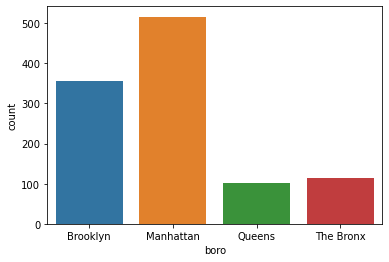

In [20]:
sns.countplot(data=dfstations, x="boro") ;

Show number of stations by Manhattan neighborhood

In [21]:
nabes = dfstations['neighborhood'].loc[dfstations['boro']== 'Manhattan'].value_counts()[:25]

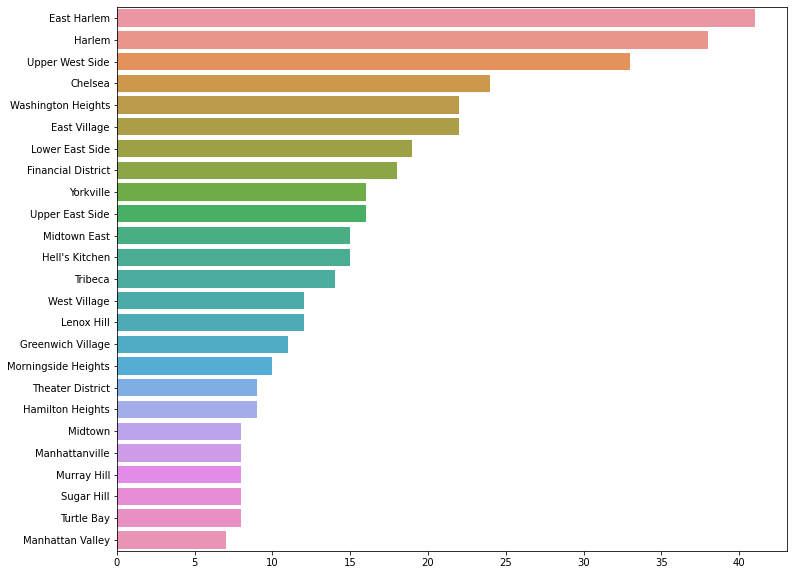

In [22]:
plt.figure(figsize=(12,10))
sns.barplot( x=nabes.values , y=list(nabes.index),  orient="h"  ) ;

### Combining Station locations with Trip Data

Join Trip Data to Station table on `start station id` equal to `stationid`

In [23]:
dfa = pd.merge(df, dfstations[['boro','neighborhood','zipcode']], how = 'left',\
               left_on='start station id', right_on='stationid')
dfa

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,boro,neighborhood,zipcode
0,4225,2020-09-01 00:00:01.0430,2020-09-01 01:10:26.6350,3508,St Nicholas Ave & Manhattan Ave,40.809725,-73.953149,116,W 17 St & 8 Ave,40.741776,-74.001497,44317,Customer,1979,1,Manhattan,Harlem,10027
1,1868,2020-09-01 00:00:04.8320,2020-09-01 00:31:13.7650,3621,27 Ave & 9 St,40.773983,-73.930913,3094,Graham Ave & Withers St,40.716981,-73.944859,37793,Customer,1991,1,Queens,Astoria,11102
2,1097,2020-09-01 00:00:06.8990,2020-09-01 00:18:24.2260,3492,E 118 St & Park Ave,40.800539,-73.941995,3959,Edgecombe Ave & W 145 St,40.823498,-73.943860,41438,Subscriber,1984,1,Manhattan,East Harlem,10035
3,1473,2020-09-01 00:00:07.7440,2020-09-01 00:24:41.1800,3946,St Nicholas Ave & W 137 St,40.818477,-73.947568,4002,W 144 St & Adam Clayton Powell Blvd,40.820877,-73.939249,35860,Customer,1990,2,Manhattan,Harlem,10040
4,1193,2020-09-01 00:00:12.2020,2020-09-01 00:20:05.5470,3081,Graham Ave & Grand St,40.711863,-73.944024,3048,Putnam Ave & Nostrand Ave,40.684020,-73.949770,26396,Customer,1969,0,Brooklyn,NaN,11206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488220,1818,2020-09-30 23:59:48.8460,2020-10-01 00:30:07.7810,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,3836,Bushwick Ave & Linden St,40.691460,-73.921460,36220,Subscriber,1993,1,Manhattan,West Village,10014
2488221,1553,2020-09-30 23:59:53.7240,2020-10-01 00:25:47.1760,390,Duffield St & Willoughby St,40.692216,-73.984284,3799,6 Ave & W 34 St,40.749640,-73.988050,31092,Subscriber,1995,1,Brooklyn,Downtown Brooklyn,11201
2488222,626,2020-09-30 23:59:54.6670,2020-10-01 00:10:21.6050,3901,Stanhope St & Fairview Ave,40.709980,-73.911160,3083,Bushwick Ave & Powers St,40.712477,-73.941000,47224,Subscriber,1954,2,Queens,Ridgewood,11237
2488223,325,2020-09-30 23:59:56.2120,2020-10-01 00:05:21.3060,3148,E 84 St & 1 Ave,40.775655,-73.950686,3338,2 Ave & E 99 St,40.786259,-73.945526,16759,Subscriber,1995,2,Manhattan,Yorkville,10028


Count number of trips by borough where they started

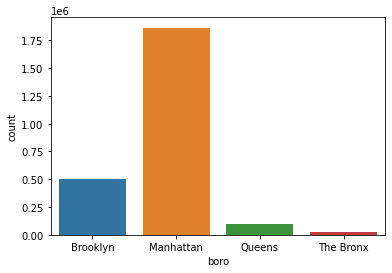

In [24]:
sns.countplot(data=dfa, x="boro") ;

Join Trip Data to Station table on `end station id`

In [25]:
dfa=pd.merge(dfa, dfstations[['boro','neighborhood','zipcode']],\
how = 'left',left_on='end station id', right_on='stationid')

Count trips by starting and ending borough

In [26]:
trips=dfa.value_counts(['boro_x','boro_y'])[:10]
trip_names=[trips.index[t][0] + ' / ' + trips.index[t][1] for t in range(len(trips)) ]

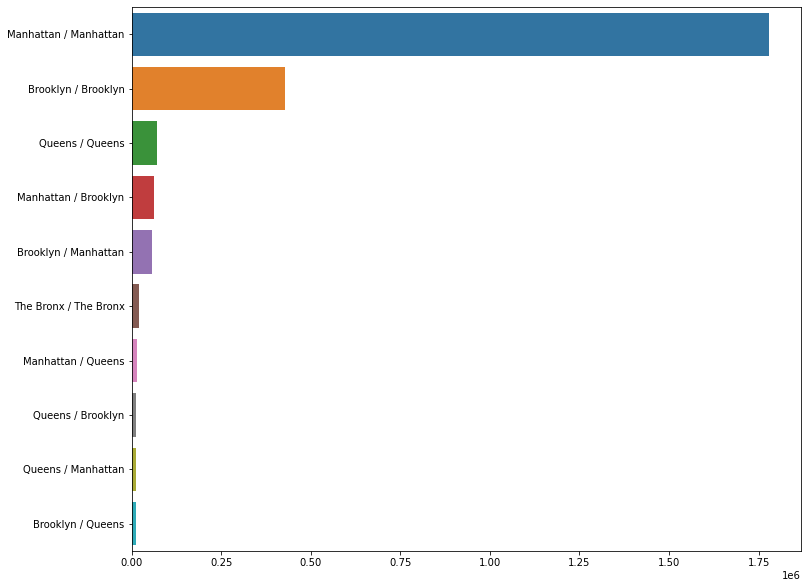

In [27]:
plt.figure(figsize=(12,10))
sns.barplot( x= list(trips.values), y = trip_names, orient="h") ;

In [28]:
trips=dfa.value_counts(['neighborhood_x','neighborhood_y'])[:25]
trip_names=[trips.index[t][0] + ' / ' + trips.index[t][1] for t in range(len(trips)) ]

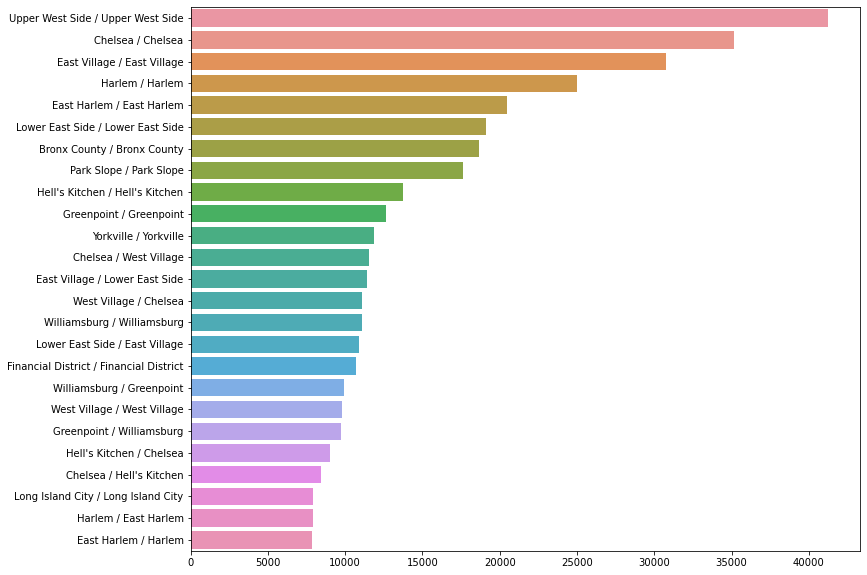

In [29]:
plt.figure(figsize=(12,10))
sns.barplot( x= list(trips.values), y = trip_names, orient="h") ;